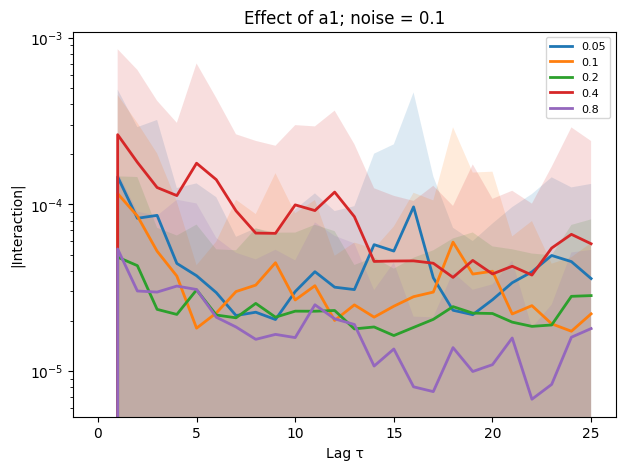

In [3]:
import os, re, pickle
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

def aggregate_lag_curve(lag_dict, tau_max, reduce="median"):
    """
    Aggregate lag_dict into lag curves.
    Args:
      lag_dict: {(tau, d, d'): np.ndarray[N]}
      tau_max: maximum tau
      reduce: 'median' | 'mean' (how to reduce across pairs)
    Returns:
      curve: np.ndarray[tau_max+1, N]  # per-sample lag curve
    """
    # Find N from one entry
    first_val = next(iter(lag_dict.values()))
    N = first_val.shape[0]

    curve = np.zeros((tau_max + 1, N))
    for tau in range(tau_max + 1):
        vals = [np.abs(v) for (tau_, d, d2), v in lag_dict.items() if tau_ == tau]  # list of [N]
        if vals:
            vals = np.stack(vals, axis=0)  # [num_pairs, N]
            if reduce == "median":
                curve[tau] = np.median(vals, axis=0)  # [N]
            else:
                curve[tau] = np.mean(vals, axis=0)    # [N]
        else:
            curve[tau] = 0.0
    return curve  # [tau_max+1, N]

BASE_DIR = Path("../runs/var_local")
TAU_MAX = 25  # adjust if needed

# --------------------------------
# Helpers
# --------------------------------
import re

def parse_run_name(run_dir):
    """
    Parse run folder name into a dict of hyperparams.
    Example: tau_max10_num_permutations5_coeff_scale0.2_noise0.1_explainertimex
    """
    name = run_dir.name
    params = {}

    # regex patterns for each param
    patterns = {
        "tau_max": r"tau_max(\d+)",
        "num_permutations": r"num_permutations(\d+)",
        "a1": r"a1([0-9.]+)",
        "noise": r"noise([0-9.]+)",
        "explainer": r"explainer(\w+)"
    }

    for key, pat in patterns.items():
        m = re.search(pat, name)
        if m:
            if key in ["tau_max", "num_permutations"]:
                params[key] = int(m.group(1))
            elif key in ["a1", "noise"]:
                params[key] = float(m.group(1))
            else:
                params[key] = m.group(1)

    return params


def load_curve(run_dir, tau_max=TAU_MAX, use="mean"):
    """Load aggregated curve from lag_dict_(mean|median).pkl"""
    fname = "lag_dict_mean.pkl" if use == "mean" else "lag_dict_median.pkl"
    fpath = run_dir / fname
    if not fpath.exists():
        print(f"❌ Missing {fname} in {run_dir}")
        return None

    with open(fpath, "rb") as f:
        lag_dict = pickle.load(f)

    curve = aggregate_lag_curve(lag_dict, tau_max=tau_max)
    # print(f"✅ Loaded {fname} from {run_dir}")
    return curve


def plot_grouped_curves(group_runs, tau_max=TAU_MAX, use="mean", title=None, sort_labels=True, log_y=True):
    """
    group_runs: dict[label -> list of run_dirs]
    """
    # --- ensure labels are sorted numerically before iterating ---
    if sort_labels:
        try:
            items = sorted(group_runs.items(), key=lambda kv: float(kv[0]))
        except (ValueError, TypeError):
            # fallback to string sort if labels aren't numeric
            items = sorted(group_runs.items(), key=lambda kv: str(kv[0]))
    else:
        items = group_runs.items()
        
    plt.figure(figsize=(7, 5))
    
    for label, runs in items:
        # print(label)
        curves = []
        for run_dir in runs:
            curve = load_curve(run_dir, tau_max, use)
            if curve is not None:
                curves.append(curve)

        if not curves:
            continue
        curves = np.array(curves)

        # Handle 1D or 2D curves
        if curves.ndim == 3:   # multiple [tau,N] curves stacked
            agg = curves.mean(axis=(0,2))
            std = curves.std(axis=(0,2))
        elif curves.ndim == 2: # multiple [tau] curves stacked
            agg = curves.mean(axis=0)
            std = curves.std(axis=0)
        else: # single curve
            agg = curves
            std = np.zeros_like(agg)

        plt.plot(range(len(agg)), agg, lw=2, label=str(label))
        plt.fill_between(range(len(agg)), agg-std, agg+std, alpha=0.15)

    plt.xlabel("Lag τ")
    plt.ylabel("|Interaction|")
    if log_y:
        plt.yscale("log")
    plt.title(title or f"Overlay ({use})")

    # --- sort legend labels ---
    handles, labels = plt.gca().get_legend_handles_labels()
    # if sort_labels:
    #     try:
    #         labels_numeric = [float(l) for l in labels]
    #         order = np.argsort(labels_numeric)
    #     except ValueError:
    #         order = np.argsort(labels)
    #     handles = [handles[i] for i in order]
    #     labels = [labels[i] for i in order]
    plt.legend(handles, labels, fontsize=8)

    plt.show()



# --------------------------------
# Collect all runs
# --------------------------------
all_runs = [p for p in BASE_DIR.rglob("*") if p.is_dir() and (p/"lag_dict_mean.pkl").exists()]
meta = [(r, parse_run_name(r)) for r in all_runs]
# print(meta[0])

# --------------------------------
# Example overlays
# --------------------------------

# Compare different a1 (fix noise & arch)
def group_by_a1(arch="lstm", noise=0.1):
    group = {}
    for r, params in meta:
        if params.get("noise")==noise and arch in str(r):
            group[params["a1"]] = group.get(params["a1"], []) + [r]
    return group


# Compare different noise levels (fix a1 & arch)
def group_by_noise(arch="lstm", a1=0.2):
    group = {}
    for r, params in meta:
        if params.get("a1")==a1 and arch in str(r):
            group[params["noise"]] = group.get(params["noise"], []) + [r]
    return group


# Compare different num_permutations (fix coeff_scale, noise & arch)
def group_by_permutations(arch="lstm", a1=0.2, noise=0.1):
    group = {}
    for r, params in meta:
        if params.get("a1")==a1 and params.get("noise")==noise and arch in str(r):
            group[params["num_permutations"]] = group.get(params["num_permutations"], []) + [r]
    return group


# Compare architectures (fix a1, noise, permutations)
def group_by_arch(a1=0.2, noise=0.1, num_permutations=20):
    group = {}
    for r, params in meta:
        # print(r, params)
        if (params.get("a1")==a1 and 
            params.get("noise")==noise and 
            params.get("num_permutations")==num_permutations):
            arch = r.parts[3]  # "lstm", "tcn", etc.
            # print(arch)
            group[arch] = group.get(arch, []) + [r]
    return group

logy=True
# plot_grouped_curves(group_by_a1("transformer", noise=0.05),
#                     tau_max=TAU_MAX, use="mean", title="Effect of a1; noise = 0.05", log_y=logy)

plot_grouped_curves(group_by_a1("transformer", noise=0.1),
                    tau_max=TAU_MAX, use="mean", title="Effect of a1; noise = 0.1", log_y=logy)

# plot_grouped_curves(group_by_a1("transformer", noise=0.2),
#                     tau_max=TAU_MAX, use="mean", title="Effect of a1; noise = 0.2", log_y=logy)

# plot_grouped_curves(group_by_a1("transformer", noise=0.4),
#                     tau_max=TAU_MAX, use="mean", title="Effect of a1; noise = 0.4", log_y=logy)

# plot_grouped_curves(group_by_a1("lstm", noise=0.05),
#                     tau_max=TAU_MAX, use="mean", title="Effect of a1; noise = 0.05", log_y=logy)

# plot_grouped_curves(group_by_a1("lstm", noise=0.1),
#                     tau_max=TAU_MAX, use="mean", title="Effect of a1; noise = 0.1", log_y=logy)

# plot_grouped_curves(group_by_a1("lstm", noise=0.2),
#                     tau_max=TAU_MAX, use="mean", title="Effect of a1; noise = 0.2", log_y=logy)

# plot_grouped_curves(group_by_a1("lstm", noise=0.4),
#                     tau_max=TAU_MAX, use="mean", title="Effect of a1; noise = 0.4", log_y=logy)



# plot_grouped_curves(group_by_noise("lstm", a1=0.05),
#                     tau_max=TAU_MAX, use="mean", title="Effect of noise; a1 = 0.05", log_y=logy)

# plot_grouped_curves(group_by_noise("lstm", a1=0.1),
#                     tau_max=TAU_MAX, use="mean", title="Effect of noise; a1 = 0.1", log_y=logy)

# plot_grouped_curves(group_by_noise("lstm", a1=0.2),
#                     tau_max=TAU_MAX, use="mean", title="Effect of noise; a1 = 0.2", log_y=logy)

# plot_grouped_curves(group_by_noise("lstm", a1=0.4),
#                     tau_max=TAU_MAX, use="mean", title="Effect of noise; a1 = 0.4", log_y=logy)


# plot_grouped_curves(group_by_permutations("lstm", a1=0.2, noise=0.1),
#                     tau_max=TAU_MAX, use="mean", title="Effect of num_permutations", log_y=logy)

# plot_grouped_curves(group_by_arch(a1=0.2, noise=0.1, num_permutations=20),
#                     tau_max=TAU_MAX, use="mean", title="Effect of architecture", log_y=logy)

# red blue o p g
# 2 8 05 1 4

### Loc@K and Loc50

❌ Missing metrics1.json in ../runs/var_local/lstm/ep100_bs32/tau_max20_num_permutations20_a10.8_noise0.1_coeff_scale0.2


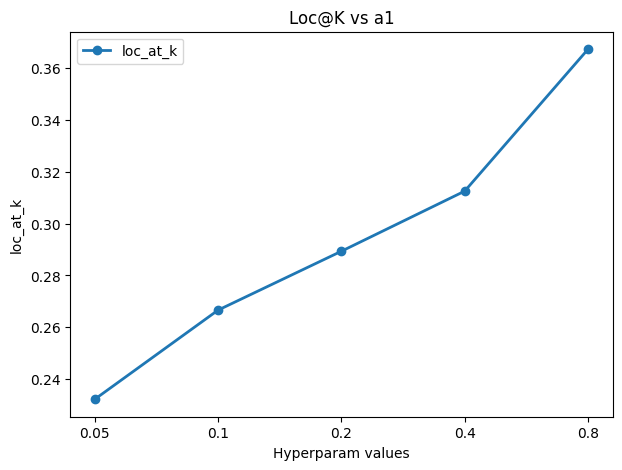

❌ Missing metrics1.json in ../runs/var_local/lstm/ep100_bs32/tau_max20_num_permutations20_a10.8_noise0.1_coeff_scale0.2


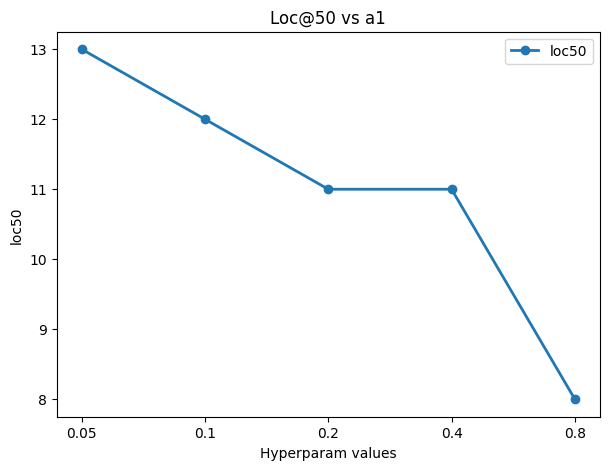

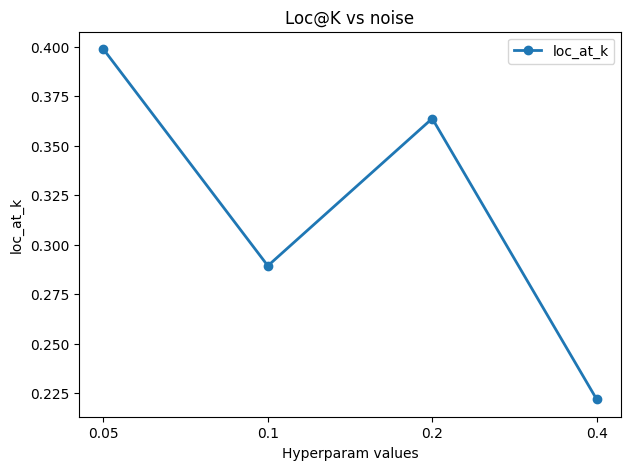

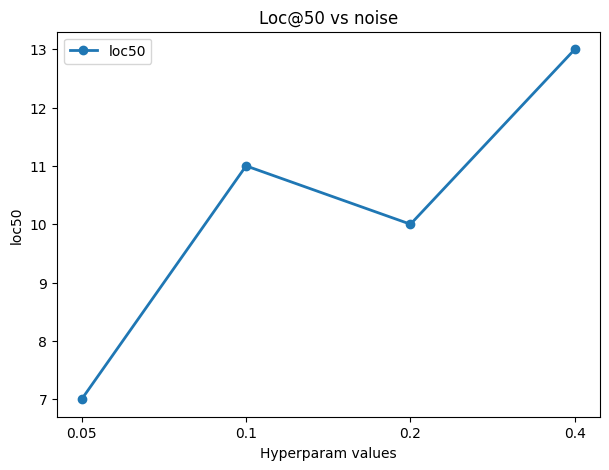

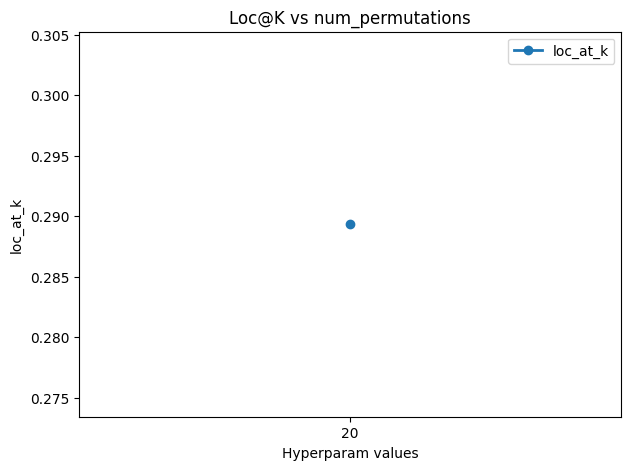

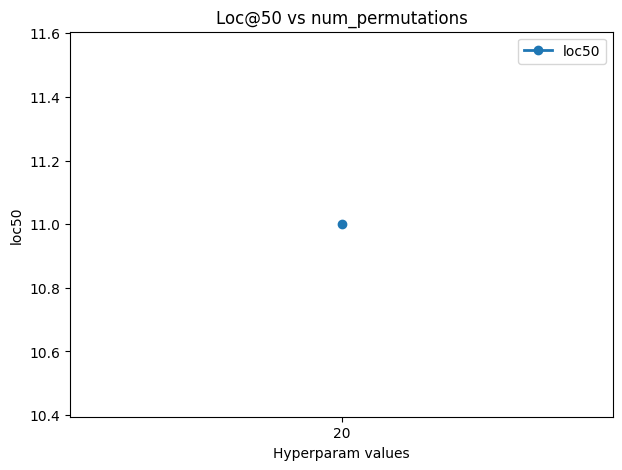

⚠️ No data to plot
⚠️ No data to plot


In [25]:
import json
import matplotlib.pyplot as plt

# -----------------------------
# Load metrics from metrics1.json
# -----------------------------
def load_metrics(run_dir):
    fpath = run_dir / "metrics1.json"
    if not fpath.exists():
        print(f"❌ Missing metrics1.json in {run_dir}")
        return None
    with open(fpath, "r") as f:
        metrics = json.load(f)
    return {
        "loc_at_k": metrics.get("loc_at_k", None),  # or whatever K you used
        "loc50": metrics.get("loc50", None)
    }
def plot_metric_group(group_runs, metric="loc_at_k", title=None, sort_labels=True):
    """
    group_runs: dict[label -> list of run_dirs]
    metric: "loc_at_k" or "loc50"
    """
    data = {}
    for label, runs in group_runs.items():
        vals = []
        for run_dir in runs:
            m = load_metrics(run_dir)
            if m and m[metric] is not None:
                vals.append(m[metric])
        if vals:
            data[label] = vals

    if not data:
        print("⚠️ No data to plot")
        return

    labels, means, stds = [], [], []
    for label, vals in data.items():
        labels.append(label)
        means.append(np.mean(vals))
        stds.append(np.std(vals))

    # sort labels if possible
    if sort_labels:
        try:
            labels_numeric = [float(l) for l in labels]
            order = np.argsort(labels_numeric)
        except ValueError:
            order = np.argsort(labels)
        labels = [labels[i] for i in order]
        means = [means[i] for i in order]
        stds = [stds[i] for i in order]

    plt.figure(figsize=(7,5))
    x = range(len(labels))
    plt.plot(x, means, marker="o", lw=2, label=metric)
    # plt.fill_between(x, np.array(means)-np.array(stds), np.array(means)+np.array(stds), alpha=0.2)
    plt.xticks(x, labels)
    plt.xlabel("Hyperparam values")
    plt.ylabel(metric)
    plt.title(title or metric)
    plt.legend()
    plt.show()


# -----------------------------
# Example comparisons
# -----------------------------
plot_metric_group(group_by_a1("lstm", noise=0.1),
                  metric="loc_at_k", title="Loc@K vs a1")

plot_metric_group(group_by_a1("lstm", noise=0.1),
                  metric="loc50", title="Loc@50 vs a1")

plot_metric_group(group_by_noise("lstm", a1=0.2),
                  metric="loc_at_k", title="Loc@K vs noise")

plot_metric_group(group_by_noise("lstm", a1=0.2),
                  metric="loc50", title="Loc@50 vs noise")

plot_metric_group(group_by_permutations("lstm", a1=0.2, noise=0.1),
                  metric="loc_at_k", title="Loc@K vs num_permutations")

plot_metric_group(group_by_permutations("lstm", a1=0.2, noise=0.1),
                  metric="loc50", title="Loc@50 vs num_permutations")

plot_metric_group(group_by_arch(a1=0.2, noise=0.1, num_permutations=5),
                  metric="loc_at_k", title="Loc@K vs architecture")

plot_metric_group(group_by_arch(a1=0.2, noise=0.1, num_permutations=5),
                  metric="loc50", title="Loc@50 vs architecture")


In [28]:
import pandas as pd

def collect_metrics(group_runs, group_name):
    """
    group_runs: dict[label -> list of run_dirs]
    Returns a DataFrame with columns [label, loc_at_k, loc50]
    """
    rows = []
    for label, runs in group_runs.items():
        vals_k, vals_50 = [], []
        for run_dir in runs:
            m = load_metrics(run_dir)
            if m:
                if m.get("loc_at_k") is not None:
                    vals_k.append(m["loc_at_k"])
                if m.get("loc50") is not None:
                    vals_50.append(m["loc50"])
        if vals_k or vals_50:
            rows.append({
                group_name: label,
                "loc_at_k": np.mean(vals_k) if vals_k else None,
                # "loc_at_k_std": np.std(vals_k) if vals_k else None,
                "loc50": np.mean(vals_50) if vals_50 else None,
                # "loc50_std": np.std(vals_50) if vals_50 else None
            })
    return pd.DataFrame(rows)


def print_group_table(group_runs, group_name):
    df = collect_metrics(group_runs, group_name)
    if df.empty:
        print(f"⚠️ No metrics found for {group_name}")
        return
    print(f"\n=== {group_name} ===")
    display(df.sort_values(group_name))


# Group by coeff_scale
print_group_table(group_by_a1("lstm", noise=0.1), "coeff_scale")

# Group by noise
print_group_table(group_by_noise("lstm", a1=0.2), "noise")

# Group by num_permutations
print_group_table(group_by_permutations("lstm", a1=0.2, noise=0.1), "num_permutations")

# Group by architecture
print_group_table(group_by_arch(a1=0.2, noise=0.1, num_permutations=20), "architecture")


❌ Missing metrics1.json in ../runs/var_local/lstm/ep100_bs32/tau_max20_num_permutations20_a10.8_noise0.1_coeff_scale0.2

=== coeff_scale ===


,coeff_scale,loc_at_k,loc50
3,0.05,0.232186,13.0
1,0.10,0.266608,12.0
4,0.20,0.289338,11.0
0,0.40,0.312548,11.0
2,0.80,0.367343,8.0



=== noise ===


,noise,loc_at_k,loc50
2,0.05,0.398671,7.0
1,0.10,0.289338,11.0
3,0.20,0.363695,10.0
0,0.40,0.221995,13.0



=== num_permutations ===


,num_permutations,loc_at_k,loc50
0,20,0.289338,11.0



=== architecture ===


,architecture,loc_at_k,loc50
1,lstm,0.289338,11.0
2,tcn,0.460961,6.0
0,transformer,0.476637,6.0
